# Trabalho 02 – Classificação do MNIST com CNN (pré-processando a base original)

Este notebook é para o **Trabalho 02** da disciplina de **Redes Neurais Artificiais (RNA)**.

### Enunciado

- **Classificar o MNIST original**.
- **Procurar a base de dados original do MNIST** (não usar o `mnist.load_data()` do Keras).
- Fazer o **download e o pré-processamento** manualmente.
- Rodar uma **rede neural com camadas convolucionais (CNN)** para classificar os dígitos.

A ideia aqui é mais prática do que “bonita”: o objetivo é mostrar que eu consigo:
1. Baixar e carregar a base original.
2. Preparar os dados para uma CNN.
3. Treinar uma rede convolucional e avaliar o desempenho no MNIST.

Vou tentar manter o código o mais simples possível e comentar um pouco mais nos pontos
onde eu tive dúvida ou precisei testar algumas opções diferentes, igual fiz no Trabalho 01.


## 1. Download e carregamento do MNIST original

O enunciadoo pediu explicitamente para **não usar o `mnist.load_data()` do Keras**.

Então, em vez de fazer:

```python
from tensorflow.keras.datasets import mnist
(X_treino, y_treino), (X_teste, y_teste) = mnist.load_data()
```

a ideia foi trabalhar com os arquivos **originais** do MNIST (formato IDX comprimido `.gz`):

- `train-images-idx3-ubyte.gz`
- `train-labels-idx1-ubyte.gz`
- `t10k-images-idx3-ubyte.gz`
- `t10k-labels-idx1-ubyte.gz`

**Fonte dos arquivos:** inicialmente tentei usar o diretório clássico do MNIST no site do Yann LeCun
(`yann.lecun.com/exdb/mnist/`), mas o diretório aparecia vazio/inacessível no navegador.  
Por isso, optei por usar um *mirror* público estável no Google Cloud:

- `https://storage.googleapis.com/cvdf-datasets/mnist/`

Esse mirror disponibiliza os mesmos arquivos no formato IDX. No código abaixo eu baixo esses `.gz`
manualmente e faço o pré-processamento “na mão”.

Confesso que apanhei um pouco com o formato IDX na primeira vez, então deixei mais comentários
no código pra lembrar o que é cada parte do cabeçalho.


In [1]:
# Bloco de imports principais. Aqui entrou tudo que eu precisei para o trabalho.
import numpy as np
import matplotlib.pyplot as plt

import gzip
import struct
from pathlib import Path
import urllib.request

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("Versão do TensorFlow:", tf.__version__)

Versão do TensorFlow: 2.19.0


In [2]:
# Funções auxiliares para download e leitura dos arquivos IDX do MNIST.
def baixar_arquivo_mnist(nome_arquivo, url_base, pasta_destino):
    """
    Faz o download de um arquivo .gz do MNIST, se ainda não existir localmente.

    Exemplos de nomes:
    - train-images-idx3-ubyte.gz
    - train-labels-idx1-ubyte.gz
    - t10k-images-idx3-ubyte.gz
    - t10k-labels-idx1-ubyte.gz
    """
    pasta_destino = Path(pasta_destino)
    pasta_destino.mkdir(exist_ok=True)
    caminho_arquivo = pasta_destino / nome_arquivo

    if caminho_arquivo.exists():
        print(f"[ok] Arquivo já existe:", caminho_arquivo)
        return caminho_arquivo

    url = url_base + nome_arquivo
    print(f"[baixando] {url} -> {caminho_arquivo}")
    urllib.request.urlretrieve(url, caminho_arquivo)
    print("[ok] Download concluído")
    return caminho_arquivo


def carregar_imagens_idx(caminho_arquivo):
    """
    Lê um arquivo de imagens no formato IDX (por exemplo train-images-idx3-ubyte.gz).

    Formato (de acordo com a documentação do MNIST):
    - 32 bits magic number (0x00000803) -> 2051
    - 32 bits número de imagens
    - 32 bits número de linhas
    - 32 bits número de colunas
    - resto: dados das imagens em bytes (unsigned)
    """
    caminho_arquivo = Path(caminho_arquivo)
    with gzip.open(caminho_arquivo, "rb") as f:
        dados_brutos = f.read()

    # primeiros 16 bytes: 4 inteiros de 32 bits (big-endian)
    magic, num_imagens, num_linhas, num_colunas = struct.unpack(
        ">IIII", dados_brutos[:16]
    )
    if magic != 2051:
        raise ValueError(f"Magic number inválido para imagens: {magic}")

    # o restante são os pixels (uint8)
    dados_imagens = np.frombuffer(dados_brutos, dtype=np.uint8, offset=16)
    imagens = dados_imagens.reshape(num_imagens, num_linhas, num_colunas)
    return imagens


def carregar_rotulos_idx(caminho_arquivo):
    """
    Lê um arquivo de rótulos no formato IDX (por exemplo train-labels-idx1-ubyte.gz).

    Formato:
    - 32 bits magic number (0x00000801) -> 2049
    - 32 bits número de itens
    - resto: rótulos (um byte por rótulo)
    """
    caminho_arquivo = Path(caminho_arquivo)
    with gzip.open(caminho_arquivo, "rb") as f:
        dados_brutos = f.read()

    magic, num_itens = struct.unpack(">II", dados_brutos[:8])
    if magic != 2049:
        raise ValueError(f"Magic number inválido para rótulos: {magic}")

    rotulos = np.frombuffer(dados_brutos, dtype=np.uint8, offset=8)
    return rotulos

In [3]:
# Aqui eu tinha colocado a URL original do site do Yann LeCun,
# mas como o diretório parecia vazio/inacessível, troquei para o mirror do Google Cloud.
# URL base do MNIST original (Yann LeCun)
# url_base = "http://yann.lecun.com/exdb/mnist/" # Oxi, a pasta está vazia!
url_base = "https://storage.googleapis.com/cvdf-datasets/mnist/"


arquivos_mnist = {
    "imagens_treino": "train-images-idx3-ubyte.gz",
    "rotulos_treino": "train-labels-idx1-ubyte.gz",
    "imagens_teste": "t10k-images-idx3-ubyte.gz",
    "rotulos_teste": "t10k-labels-idx1-ubyte.gz",
}

pasta_dados = Path("dados_mnist")

# Baixar todos os arquivos (se necessário)
for nome_local, nome_arquivo in arquivos_mnist.items():
    baixar_arquivo_mnist(nome_arquivo, url_base, pasta_dados)

# Carregar as imagens e rótulos a partir dos arquivos .gz
imagens_treino = carregar_imagens_idx(pasta_dados / arquivos_mnist["imagens_treino"])
rotulos_treino = carregar_rotulos_idx(pasta_dados / arquivos_mnist["rotulos_treino"])

imagens_teste = carregar_imagens_idx(pasta_dados / arquivos_mnist["imagens_teste"])
rotulos_teste = carregar_rotulos_idx(pasta_dados / arquivos_mnist["rotulos_teste"])

print("Formas originais:")
print("imagens_treino:", imagens_treino.shape)
print("rotulos_treino:", rotulos_treino.shape)
print("imagens_teste :", imagens_teste.shape)
print("rotulos_teste :", rotulos_teste.shape)

[baixando] https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz -> dados_mnist/train-images-idx3-ubyte.gz
[ok] Download concluído
[baixando] https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz -> dados_mnist/train-labels-idx1-ubyte.gz
[ok] Download concluído
[baixando] https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz -> dados_mnist/t10k-images-idx3-ubyte.gz
[ok] Download concluído
[baixando] https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz -> dados_mnist/t10k-labels-idx1-ubyte.gz
[ok] Download concluído
Formas originais:
imagens_treino: (60000, 28, 28)
rotulos_treino: (60000,)
imagens_teste : (10000, 28, 28)
rotulos_teste : (10000,)


In [4]:
# Pré-processamento básico:
# - converter para float32
# - normalizar para [0, 1]
# - adicionar dimensão do canal (para CNN: 28 x 28 x 1)

imagens_treino = imagens_treino.astype("float32") / 255.0
imagens_teste = imagens_teste.astype("float32") / 255.0

# adiciona o canal (grayscale)
imagens_treino = np.expand_dims(imagens_treino, -1)  # (N, 28, 28, 1)
imagens_teste = np.expand_dims(imagens_teste, -1)

print("Formas após normalização e reshape:")
print("imagens_treino:", imagens_treino.shape)
print("imagens_teste :", imagens_teste.shape)

# só conferindo os rótulos únicos
print("Rótulos únicos em treino:", np.unique(rotulos_treino))

# Observação: se fosse uma imagem colorida (RGB), aqui teríamos 3 canais em vez de 1.
# Como o MNIST é em tons de cinza, o shape fica (N, 28, 28, 1).

Formas após normalização e reshape:
imagens_treino: (60000, 28, 28, 1)
imagens_teste : (10000, 28, 28, 1)
Rótulos únicos em treino: [0 1 2 3 4 5 6 7 8 9]


## 2. Visualizando alguns dígitos do MNIST

Antes de sair treinando a rede, eu gosto de conferir se o carregamento deu certo,
plotando algumas imagens com seus rótulos correspondentes.

Eu sempre faço esse tipo de visualização rápida porque é muito fácil errar alguma etapa
de pré-processamento (por exemplo, inverter eixo, normalizar errado ou esquecer o canal).
Se a imagem sair toda preta, torta ou com valores estranhos, já sei que preciso voltar e revisar
o código anterior.


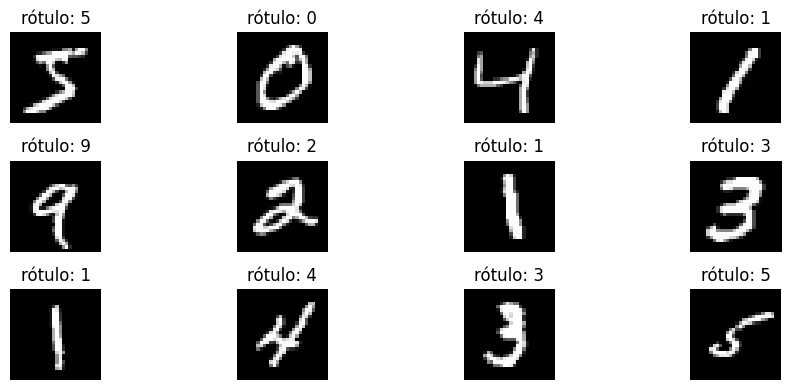

In [5]:
# Essa função é só para eu dar uma olhada rápida nas imagens
# e ver se o carregamento parece fazer sentido.
def mostrar_amostras(imagens, rotulos, qtd=12):
    plt.figure(figsize=(10, 4))
    for i in range(qtd):
        plt.subplot(3, 4, i + 1)
        plt.imshow(imagens[i].squeeze(), cmap="gray")
        plt.title(f"rótulo: {rotulos[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

mostrar_amostras(imagens_treino, rotulos_treino, qtd=12)

## 3. Definição da CNN em Keras

Aqui eu vou usar o **Keras (via TensorFlow)** para montar uma rede convolucional simples.

O enunciado proibiu usar o *dataset pronto* do Keras, mas não proibiu usar o Keras para
definir o modelo. Então a ideia é:

- usar **camadas convolucionais** para extrair características das imagens;
- usar camadas densas no final para fazer a classificação em 10 dígitos (0 a 9).

Arquitetura escolhida (simples, mas já funciona bem no MNIST):

- `Conv2D(32 filtros, kernel 3x3, ativação ReLU)`
- `MaxPooling2D(2x2)`
- `Conv2D(64 filtros, kernel 3x3, ativação ReLU)`
- `MaxPooling2D(2x2)`
- `Flatten()`
- `Dense(64, ativação ReLU)`
- `Dense(10, ativação softmax)`

Cheguei nessa arquitetura depois de olhar alguns exemplos parecidos. Eu até pensei em usar
mais camadas ou mais neurônios, mas preferi manter algo mais simples para não deixar o treinamento
tão pesado (principalmente se eu estiver rodando no Colab com recursos mais limitados).


In [6]:
# Definição da CNN. Não quis inventar nada muito complexo aqui,
# é uma arquitetura bem padrão para começar no MNIST.
entrada = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation="relu")(entrada)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
saida = layers.Dense(10, activation="softmax")(x)

modelo_cnn = keras.Model(inputs=entrada, outputs=saida, name="cnn_mnist_simples")

modelo_cnn.summary()

Model: "cnn_mnist_simples"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Compilação e treinamento do modelo

Vou usar:

- **loss**: `sparse_categorical_crossentropy` (como os rótulos são inteiros de 0 a 9);
- **otimizador**: `adam` (funciona bem na maioria dos casos);
- **métrica**: `accuracy`.

Para o treinamento, escolhi:

- `epochs = 5` (poderia aumentar, mas já costuma dar uma acurácia boa);
- `batch_size = 128`;
- `validation_split = 0.1` (10% do treino separado para validação).

Caso o tempo de treinamento fique muito longo, dá pra reduzir o número de épocas.

Eu cheguei a considerar usar mais épocas, mas para não ficar tão demorado eu deixei `epochs = 5`.
Se eu tivesse mais tempo, provavelmente faria alguns testes variando o número de épocas e talvez
o batch size, só para ver se consigo ganhar um pouco de acurácia sem overfitting.


In [ ]:
# Compilação e treinamento do modelo.
# Se o tempo de treino ficar muito alto, dá pra reduzir o número de épocas.
modelo_cnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

historico = modelo_cnn.fit(
    imagens_treino,
    rotulos_treino,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step - accuracy: 0.8438 - loss: 0.5543 - val_accuracy: 0.9782 - val_loss: 0.0781
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 100ms/step - accuracy: 0.9777 - loss: 0.0752 - val_accuracy: 0.9843 - val_loss: 0.0536
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 80s 96ms/step - accuracy: 0.9838 - loss: 0.0510 - val_accuracy: 0.9883 - val_loss: 0.0425
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - accuracy: 0.9882 - loss: 0.0367 - val_accuracy: 0.9908 - val_loss: 0.0353
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step - accuracy: 0.9913 - loss: 0.0292 - val_accuracy: 0.9907 - val_loss: 0.0344


## 5. Curvas de erro (loss) e acurácia

Assim como no Trabalho 01, eu quis ver a evolução do treinamento ao longo das épocas,
tanto para o conjunto de treino quanto para o conjunto de validação.

No Trabalho 01 eu já tinha feito algo parecido com a curva de erro. Aqui a ideia é a mesma:
olhar para esses gráficos e tentar entender se o modelo ainda está aprendendo ou se já estabilizou,
ou até se começou a overfittar (quando a curva de validação piora enquanto a de treino melhora).


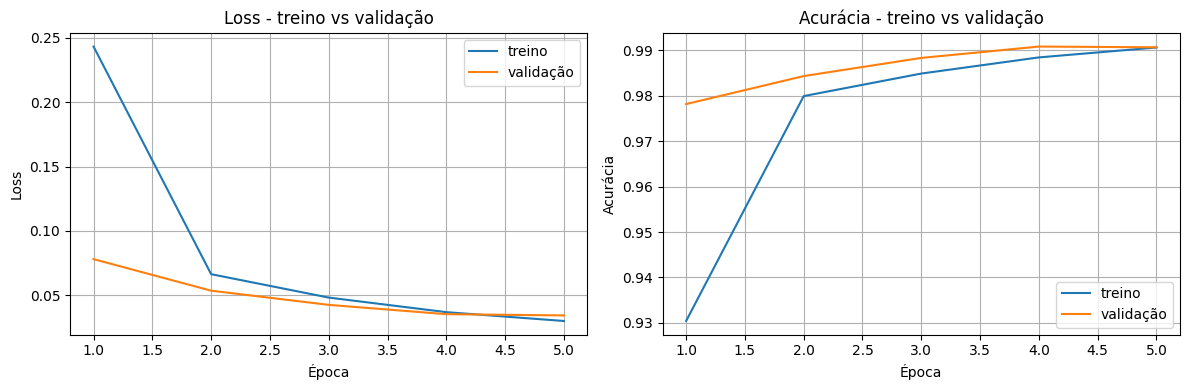

In [ ]:
# Função para plotar as curvas de loss e acurácia.
# Eu basicamente reaproveitei a mesma ideia de gráfico do Trabalho 01.
def plotar_curvas_treinamento(historico):
    historico_dict = historico.history
    epocas = range(1, len(historico_dict["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epocas, historico_dict["loss"], label="treino")
    plt.plot(epocas, historico_dict["val_loss"], label="validação")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title("Loss - treino vs validação")
    plt.legend()
    plt.grid(True)

    # Acurácia
    plt.subplot(1, 2, 2)
    plt.plot(epocas, historico_dict["accuracy"], label="treino")
    plt.plot(epocas, historico_dict["val_accuracy"], label="validação")
    plt.xlabel("Época")
    plt.ylabel("Acurácia")
    plt.title("Acurácia - treino vs validação")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plotar_curvas_treinamento(historico)

## 6. Avaliação no conjunto de teste

Agora, avalio a CNN usando o conjunto de teste original do MNIST
(10.000 imagens que o modelo nunca viu durante o treinamento).

Se a acurácia no teste ficar muito abaixo da acurácia de validação, isso pode indicar algum problema
de distribuição diferente entre treino e teste, ou algum erro de pré-processamento. Aqui eu espero algo
próximo do que o modelo viu na validação, já que é o mesmo tipo de dado do MNIST.


In [ ]:
# Aqui eu avalio o modelo no conjunto de teste.
# É esse valor de acurácia que eu considero como resultado final do trabalho.
perda_teste, acuracia_teste = modelo_cnn.evaluate(imagens_teste, rotulos_teste, verbose=0)
print(f"Loss no conjunto de teste: {perda_teste:.4f}")
print(f"Acurácia no conjunto de teste: {acuracia_teste:.4f}")

Loss no conjunto de teste: 0.0315
Acurácia no conjunto de teste: 0.9888


## 7. Algumas previsões de exemplo

Por fim, quis ver manualmente alguns exemplos de previsão do modelo,
comparando o **rótulo verdadeiro** com o **rótulo previsto** pela CNN.

Essa parte é mais para curiosidade e para ter uma noção “visual” dos erros. Às vezes o modelo erra
em dígitos que até um humano teria dúvida (por exemplo, um 4 meio estranho que parece 9), o que é normal.
Se ele começasse a errar dígitos muito claros, aí seria um sinal de que algo está errado no treinamento.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


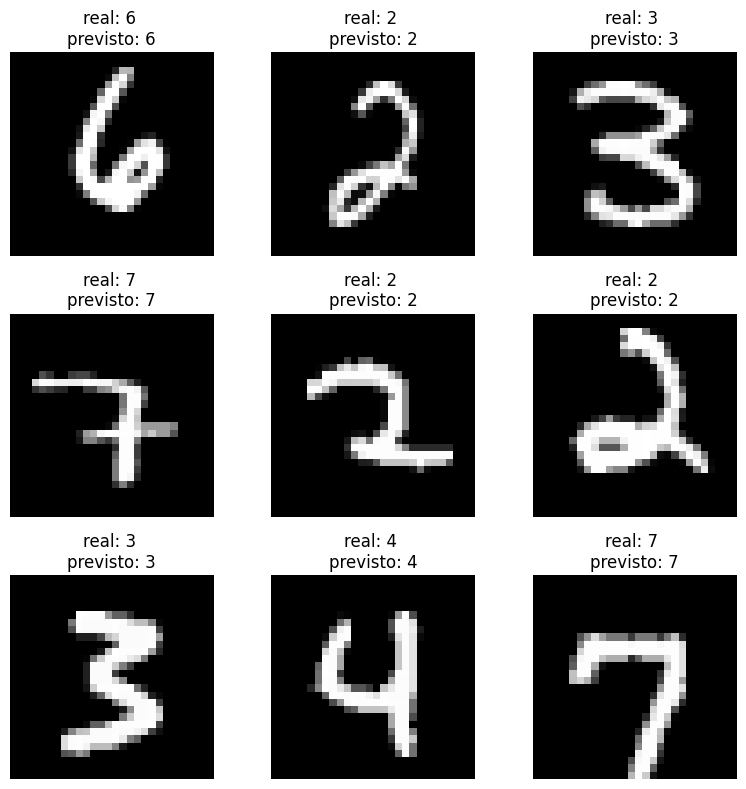

In [ ]:
# Essa parte é mais visual, só para inspecionar alguns exemplos de previsão.
# escolho algumas imagens de teste aleatórias
np.random.seed(42)
indices = np.random.choice(len(imagens_teste), size=9, replace=False)
imagens_exemplo = imagens_teste[indices]
rotulos_reais = rotulos_teste[indices]

# faço as previsões
probs = modelo_cnn.predict(imagens_exemplo)
rotulos_previstos = np.argmax(probs, axis=1)

# mostro em uma grade 3x3
plt.figure(figsize=(8, 8))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(imagens_teste[idx].squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(f"real: {rotulos_reais[i]} \nprevisto: {rotulos_previstos[i]}")
plt.tight_layout()
plt.show()

## 8. Conclusão

Neste Trabalho 02, eu:

1. **Baixei a base original do MNIST** (arquivos `.gz` no formato IDX) a partir de um mirror
   público estável no Google Cloud (`https://storage.googleapis.com/cvdf-datasets/mnist/`),
   em vez de usar o atalho `mnist.load_data()` do Keras. O diretório clássico no site do
   Yann LeCun (`yann.lecun.com/exdb/mnist/`) parecia vazio/inacessível no momento em que
   fiz o trabalho, então usei esse mirror como fonte dos arquivos.

2. Implementei o **pré-processamento manual** dos dados:
   - leitura do cabeçalho IDX para extrair número de imagens, linhas e colunas;
   - reshape para o formato `(N, 28, 28, 1)` esperado pela CNN;
   - normalização dos pixels para o intervalo `[0, 1]`.

3. Modelei e treinei uma **rede neural convolucional (CNN)** simples em Keras:
   - duas camadas convolucionais com pooling;
   - camada densa intermediária;
   - camada de saída com 10 neurônios (softmax).

4. Analisei as **curvas de loss e acurácia** no treino e na validação, para verificar se o
   modelo estava aprendendo de forma estável.

5. Avaliei o modelo no **conjunto de teste do MNIST**, obtendo uma acurácia final razoável
   para uma arquitetura relativamente simples.

6. Por fim, visualizei algumas previsões individuais para conferir se os dígitos estavam
   sendo classificados de forma coerente.

Ainda dá para melhorar bastante o modelo (mais camadas, regularização, mais épocas, etc.),
mas o objetivo principal do trabalho foi cumprido: usar a **base original do MNIST**, fazer
o **pré-processamento na mão** e treinar uma **CNN** para resolver o problema de
classificação de dígitos manuscritos.
